## Connect and check environment, add packages

### Environment & packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
!pip list | grep pandas
!pip list | grep pyarrow
# !pip install pyarrow
!pip install optuna

pandas                        1.3.5
pandas-datareader             0.9.0
pandas-gbq                    0.13.3
pandas-profiling              1.4.1
sklearn-pandas                1.8.0
pyarrow                       6.0.1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns

### Load data

In [ ]:
## Load data
filepath='/content/drive/MyDrive/Colab Notebooks/Kaggle_Youtubelikes/'
testfile = filepath+'test.parquet'
test_df=pd.read_parquet(testfile, engine = 'auto')
trainfile = filepath+'train.parquet'
train_df=pd.read_parquet(trainfile, engine = 'auto')

### Without thumbnail info

#### "categoryId"

In [ ]:
from sklearn import preprocessing 
encoder = preprocessing.LabelEncoder()
train_df['categoryId'] = encoder.fit_transform(train_df.categoryId)
test_df['categoryId'] = encoder.transform(test_df.categoryId)

#### Make use of info for the same video:
* "Index", "last_target", "missing_last_target"

In [ ]:
train_df['index']=train_df.index

In [ ]:
train_dic = train_df.video_id.value_counts().to_dict()
test_dic = test_df.video_id.value_counts().to_dict()

In [ ]:
videos=[]
for i in list(train_dic.keys()):
    if i in list(test_dic.keys()):
        videos.append([i,train_dic[i],test_dic[i]])
        
videos_multiple = []
videos_one = []
for i in videos:
    if i[1]==1:
        videos_one.append(i[0])
    else:
        videos_multiple.append(i[0])

In [ ]:
#for test data
def get_latest_target(video_id):
    targets= list(train_df.query('video_id ==@video_id').target)
    if len(targets)==0:
        return train_df[train_df.ratings_disabled==0].target.mean()
    return targets[-1]

# for train data
def get_last_target(video_id,index):
    targets= list(train_df.query('video_id ==@video_id & index<=@index').target)
    if len(targets)==1:
        return targets[-1]
    else:
        return targets[-2]

In [ ]:
ls = videos_multiple+videos_one
df = train_df.query('video_id in @ls')
df['last_target']= [get_last_target(a,b) for a,b in zip(df.video_id,df.index)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train_df['last_target'] =train_df['index'].map(df.set_index(['index']).last_target.to_dict())

In [ ]:
train_df['missing_last_target'] = train_df['last_target'].isna()

In [ ]:
train_df['last_target'] = train_df.last_target.fillna(train_df[train_df.ratings_disabled==0].target.mean())

In [ ]:
ls = videos_multiple+videos_one
df = train_df.query('video_id in @ls')
df['last_target']= [get_latest_target(a) for a in df.video_id]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test_df['last_target'] =test_df['video_id'].map(df.set_index('video_id').last_target.to_dict())

In [ ]:
test_df['missing_last_target'] = test_df['last_target'].isna()

In [ ]:
test_df.last_target =test_df['last_target'].fillna(train_df[train_df.ratings_disabled==0].target.mean())

#### Make use of the same channel and category
* ver 1: "target_average_channel", "target_std_channel", "target_average_category","target_std_category". "likes_average_channel","likes_average_category", "dislikes_average_channel","dislikes_average_category", "views_average_channel","views_average_category", "comments_average_channel","comments_average_category"
* ver 2 +:"likes_std_channel","likes_std_category", "dislikes_std_channel","dislikes_std_category", "views_std_channel","views_std_category", "comments_std_channel","comments_std_category"

In [ ]:
# train_df[train_df.ratings_disabled==0].groupby(by=['channelTitle'])['target'].std()

In [ ]:
averages_channel = train_df[train_df.ratings_disabled==0].groupby(by=['channelTitle']).mean('target')['target'].to_dict()
averages_category = train_df[train_df.ratings_disabled==0].groupby(by=['categoryId']).mean('target')['target'].to_dict()

std_channel = train_df[train_df.ratings_disabled==0].groupby(by=['channelTitle'])['target'].std().to_dict()
std_category = train_df[train_df.ratings_disabled==0].groupby(by=['categoryId'])['target'].std().to_dict()

In [ ]:
train_df['target_average_channel'] = [averages_channel[a] if a in averages_channel.keys() else 0 for a in train_df.channelTitle]
test_df['target_average_channel'] = [averages_channel[a] if a in averages_channel.keys() else averages_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

train_df['target_std_channel'] = [std_channel[a] if a in std_channel.keys() else 0 for a in train_df.channelTitle]
test_df['target_std_channel'] = [std_channel[a] if a in std_channel.keys() else std_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]


In [ ]:
train_df['target_average_category'] = [averages_category[a] if a in averages_category.keys() else 0  for a in train_df.categoryId]
test_df['target_average_category'] = [averages_category[a] if a in averages_category.keys() else 0  for a in test_df.categoryId]

train_df['target_std_category'] = [std_category[a] if a in std_category.keys() else 0  for a in train_df.categoryId]
test_df['target_std_category'] = [std_category[a] if a in std_category.keys() else 0  for a in test_df.categoryId]

In [ ]:
# # likes
# averageslikes_channel = train_df[train_df.ratings_disabled==0].groupby(by=['channelTitle']).mean('likes')['likes'].to_dict()
# averageslikes_category = train_df[train_df.ratings_disabled==0].groupby(by=['categoryId']).mean('likes')['likes'].to_dict()

# train_df['likes_average_channel'] = [averageslikes_channel[a] if a in averageslikes_channel.keys() else 0 for a in train_df.channelTitle]
# test_df['likes_average_channel'] = [averageslikes_channel[a] if a in averageslikes_channel.keys() else averageslikes_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

# train_df['likes_average_category'] = [averageslikes_category[a] if a in averageslikes_category.keys() else 0  for a in train_df.categoryId]
# test_df['likes_average_category'] = [averageslikes_category[a] if a in averageslikes_category.keys() else 0  for a in test_df.categoryId]


averageslikes_channel = train_df[train_df.ratings_disabled==0].groupby(by=['channelTitle']).mean('likes')['likes'].to_dict()
averageslikes_category = train_df[train_df.ratings_disabled==0].groupby(by=['categoryId']).mean('likes')['likes'].to_dict()

std_likes_channel = train_df[train_df.ratings_disabled==0].groupby(by=['channelTitle'])['likes'].std().to_dict()
std_likes_category = train_df[train_df.ratings_disabled==0].groupby(by=['categoryId'])['likes'].std().to_dict()


train_df['likes_average_channel'] = [averageslikes_channel[a] if a in averageslikes_channel.keys() else 0 for a in train_df.channelTitle]
test_df['likes_average_channel'] = [averageslikes_channel[a] if a in averageslikes_channel.keys() else averageslikes_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

train_df['likes_std_channel'] = [std_likes_channel[a] if a in std_likes_channel.keys() else 0 for a in train_df.channelTitle]
test_df['likes_std_channel'] = [std_likes_channel[a] if a in std_likes_channel.keys() else std_likes_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]


train_df['likes_average_category'] = [averageslikes_category[a] if a in averageslikes_category.keys() else 0  for a in train_df.categoryId]
test_df['likes_average_category'] = [averageslikes_category[a] if a in averageslikes_category.keys() else 0  for a in test_df.categoryId]

train_df['likes_std_category'] = [std_likes_category[a] if a in std_likes_category.keys() else 0 for a in train_df.categoryId]
test_df['likes_std_category'] = [std_likes_category[a] if a in std_likes_category.keys() else std_likes_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]


# #dislikes
# averagesdislikes_channel = train_df[train_df.ratings_disabled==0].groupby(by=['channelTitle']).mean('dislikes')['dislikes'].to_dict()
# averagesdislikes_category = train_df[train_df.ratings_disabled==0].groupby(by=['categoryId']).mean('dislikes')['dislikes'].to_dict()

# train_df['dislikes_average_channel'] = [averagesdislikes_channel[a] if a in averagesdislikes_channel.keys() else 0 for a in train_df.channelTitle]
# test_df['dislikes_average_channel'] = [averagesdislikes_channel[a] if a in averagesdislikes_channel.keys() else averagesdislikes_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

# train_df['dislikes_average_category'] = [averagesdislikes_category[a] if a in averagesdislikes_category.keys() else 0  for a in train_df.categoryId]
# test_df['dislikes_average_category'] = [averagesdislikes_category[a] if a in averagesdislikes_category.keys() else 0  for a in test_df.categoryId]

#dislikes
averagesdislikes_channel = train_df[train_df.ratings_disabled==0].groupby(by=['channelTitle']).mean('dislikes')['dislikes'].to_dict()
averagesdislikes_category = train_df[train_df.ratings_disabled==0].groupby(by=['categoryId']).mean('dislikes')['dislikes'].to_dict()

std_dislikes_channel = train_df[train_df.ratings_disabled==0].groupby(by=['channelTitle'])['dislikes'].std().to_dict()
std_dislikes_category = train_df[train_df.ratings_disabled==0].groupby(by=['categoryId'])['dislikes'].std().to_dict()

train_df['dislikes_average_channel'] = [averagesdislikes_channel[a] if a in averagesdislikes_channel.keys() else 0 for a in train_df.channelTitle]
test_df['dislikes_average_channel'] = [averagesdislikes_channel[a] if a in averagesdislikes_channel.keys() else averagesdislikes_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

train_df['dislikes_std_channel'] = [std_dislikes_channel[a] if a in std_dislikes_channel.keys() else 0 for a in train_df.channelTitle]
test_df['dislikes_std_channel'] = [std_dislikes_channel[a] if a in std_dislikes_channel.keys() else std_dislikes_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]


train_df['dislikes_average_category'] = [averagesdislikes_category[a] if a in averagesdislikes_category.keys() else 0  for a in train_df.categoryId]
test_df['dislikes_average_category'] = [averagesdislikes_category[a] if a in averagesdislikes_category.keys() else 0  for a in test_df.categoryId]

train_df['dislikes_std_category'] = [std_dislikes_category[a] if a in std_dislikes_category.keys() else 0 for a in train_df.categoryId]
test_df['dislikes_std_category'] = [std_dislikes_category[a] if a in std_dislikes_category.keys() else std_dislikes_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]
# #view_count
# averagesviews_channel = train_df.groupby(by=['channelTitle']).mean('view_count')['view_count'].to_dict()
# averagesviews_category = train_df.groupby(by=['categoryId']).mean('view_count')['view_count'].to_dict()

# train_df['views_average_channel'] = [averagesviews_channel[a] if a in averagesviews_channel.keys() else 0 for a in train_df.channelTitle]
# test_df['views_average_channel'] = [averagesviews_channel[a] if a in averagesviews_channel.keys() else averagesviews_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

# train_df['views_average_category'] = [averagesviews_category[a] if a in averagesviews_category.keys() else 0  for a in train_df.categoryId]
# test_df['views_average_category'] = [averagesviews_category[a] if a in averagesviews_category.keys() else 0  for a in test_df.categoryId]

#view_count
averagesviews_channel = train_df.groupby(by=['channelTitle']).mean('view_count')['view_count'].to_dict()
averagesviews_category = train_df.groupby(by=['categoryId']).mean('view_count')['view_count'].to_dict()

std_views_channel = train_df.groupby(by=['channelTitle'])['view_count'].std().to_dict()
std_views_category = train_df.groupby(by=['categoryId'])['view_count'].std().to_dict()

train_df['views_average_channel'] = [averagesviews_channel[a] if a in averagesviews_channel.keys() else 0 for a in train_df.channelTitle]
test_df['views_average_channel'] = [averagesviews_channel[a] if a in averagesviews_channel.keys() else averagesviews_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

train_df['views_std_channel'] = [std_views_channel[a] if a in std_views_channel.keys() else 0 for a in train_df.channelTitle]
test_df['views_std_channel'] = [std_views_channel[a] if a in std_views_channel.keys() else std_views_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]


train_df['views_average_category'] = [averagesviews_category[a] if a in averagesviews_category.keys() else 0  for a in train_df.categoryId]
test_df['views_average_category'] = [averagesviews_category[a] if a in averagesviews_category.keys() else 0  for a in test_df.categoryId]

train_df['views_std_category'] = [std_views_category[a] if a in std_views_category.keys() else 0 for a in train_df.channelTitle]
test_df['views_std_category'] = [std_views_category[a] if a in std_views_category.keys() else std_views_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]


# #comment_count
# averagescomment_channel = train_df[train_df.comments_disabled==0].groupby(by=['channelTitle']).mean('comment_count')['comment_count'].to_dict()
# averagescomment_category = train_df[train_df.comments_disabled==0].groupby(by=['categoryId']).mean('comment_count')['comment_count'].to_dict()

# train_df['comment_average_channel'] = [averagescomment_channel[a] if a in averagescomment_channel.keys() else 0 for a in train_df.channelTitle]
# test_df['comment_average_channel'] = [averagescomment_channel[a] if a in averagescomment_channel.keys() else averagescomment_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

# train_df['comment_average_category'] = [averagescomment_category[a] if a in averagescomment_category.keys() else 0  for a in train_df.categoryId]
# test_df['comment_average_category'] = [averagescomment_category[a] if a in averagescomment_category.keys() else 0  for a in test_df.categoryId]
#comment_count
averagescomment_channel = train_df[train_df.comments_disabled==0].groupby(by=['channelTitle']).mean('comment_count')['comment_count'].to_dict()
averagescomment_category = train_df[train_df.comments_disabled==0].groupby(by=['categoryId']).mean('comment_count')['comment_count'].to_dict()

std_comment_channel = train_df[train_df.comments_disabled==0].groupby(by=['channelTitle'])['comment_count'].std().to_dict()
std_comment_category = train_df[train_df.comments_disabled==0].groupby(by=['categoryId'])['comment_count'].std().to_dict()

train_df['comment_average_channel'] = [averagescomment_channel[a] if a in averagescomment_channel.keys() else 0 for a in train_df.channelTitle]
test_df['comment_average_channel'] = [averagescomment_channel[a] if a in averagescomment_channel.keys() else averagescomment_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

train_df['comment_std_channel'] = [std_comment_channel[a] if a in std_comment_channel.keys() else 0 for a in train_df.channelTitle]
test_df['comment_std_channel'] = [std_comment_channel[a] if a in std_comment_channel.keys() else std_comment_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]


train_df['comment_average_category'] = [averagescomment_category[a] if a in averagescomment_category.keys() else 0  for a in train_df.categoryId]
test_df['comment_average_category'] = [averagescomment_category[a] if a in averagescomment_category.keys() else 0  for a in test_df.categoryId]

train_df['comment_std_category'] = [std_comment_category[a] if a in std_comment_category.keys() else 0 for a in train_df.channelTitle]
test_df['comment_std_category'] = [std_comment_category[a] if a in std_comment_category.keys() else std_comment_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]


In [ ]:
# train_df.groupby(by=['channelTitle']).sum('view_count').view_count.sort_values(ascending=False)
# train_df.groupby(by=['channelTitle']).target.mean().sort_values(ascending=False)

In [ ]:
# top_video = train_df['video_id'].value_counts().index[0]
# train_df.query('video_id ==@top_video')

# train_df.query('video_id ==@top_video').set_index('trending_date')['view_count'].plot(figsize=(12,5),style='.-',color='red')

#### Make use of "dates"
* ver 1"days_old", "seconds_old", "DayofWeek_trending","DayofWeek_published", "Friday_trending", "Thur_trending", "Friday_published", "Sunday_published"
* ver2 +: "day_avg_channel","day_std_channel","day_avg_category","day_std_category"

In [ ]:
train_df['trending_date'] = pd.to_datetime(train_df['trending_date'],utc=True)
test_df['trending_date'] = pd.to_datetime(test_df['trending_date'],utc=True)


In [ ]:
train_df['days_old']=(train_df['trending_date'].dt.date - train_df['publishedAt'].dt.date).dt.days
test_df['days_old']=(test_df['trending_date'].dt.date - test_df['publishedAt'].dt.date).dt.days


#Additionaly, second old also would be a good indicator too
#I found out it when I read  https://www.kaggle.com/robikscube/pog-on-youtube-lgbm/notebook

train_df['seconds_old'] = (train_df['trending_date'] - train_df['publishedAt']).dt.total_seconds().astype('int')
test_df['seconds_old'] = (test_df['trending_date'] - test_df['publishedAt']).dt.total_seconds().astype('int')

In [ ]:
#dayOfWeek={'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
train_df['DayofWeek_trending'] = train_df.trending_date.dt.dayofweek
test_df['DayofWeek_trending'] = test_df.trending_date.dt.dayofweek

train_df['DayofWeek_published'] = train_df.publishedAt.dt.dayofweek
test_df['DayofWeek_published'] = test_df.publishedAt.dt.dayofweek

In [ ]:
averages_day_channel = train_df.groupby(by=['channelTitle'])['days_old'].mean().to_dict()
averages_day_category = train_df.groupby(by=['categoryId'])['days_old'].mean().to_dict()

std_day_channel = train_df.groupby(by=['channelTitle'])['days_old'].std().to_dict()
std_day_category = train_df.groupby(by=['categoryId'])['days_old'].std().to_dict()


train_df['day_average_channel'] = [averages_day_channel[a] if a in averages_day_channel.keys() else 0 for a in train_df.channelTitle]
test_df['day_average_channel'] = [averages_day_channel[a] if a in averages_day_channel.keys() else averages_day_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

train_df['day_std_channel'] = [std_day_channel[a] if a in std_day_channel.keys() else 0 for a in train_df.channelTitle]
test_df['day_std_channel'] = [std_day_channel[a] if a in std_day_channel.keys() else std_day_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]


train_df['day_average_category'] = [averages_day_category[a] if a in averages_day_category.keys() else 0  for a in train_df.categoryId]
test_df['day_average_category'] = [averages_day_category[a] if a in averages_day_category.keys() else 0  for a in test_df.categoryId]

train_df['day_std_category'] = [std_day_category[a] if a in std_day_category.keys() else 0 for a in train_df.categoryId]
test_df['day_std_category'] = [std_day_category[a] if a in std_day_category.keys() else std_day_category[b] for a,b in zip(test_df.channelTitle,test_df.categoryId)]

In [ ]:
train_df['DayofWeek_trending'] = train_df.trending_date.dt.dayofweek
test_df['DayofWeek_trending'] = test_df.trending_date.dt.dayofweek

train_df['DayofWeek_published'] = train_df.publishedAt.dt.dayofweek
test_df['DayofWeek_published'] = test_df.publishedAt.dt.dayofweek

In [ ]:
#make some features from the insight 

train_df['Friday_Trending'] = [1 if a ==4 else 0 for a in train_df.DayofWeek_trending]
test_df['Friday_Trending'] = [1 if a ==4 else 0 for a in test_df.DayofWeek_trending]

train_df['Thursday_Trending'] = [1 if a ==3 else 0 for a in train_df.DayofWeek_trending]
test_df['Thursday_Trending'] = [1 if a ==3 else 0 for a in test_df.DayofWeek_trending]


train_df['Friday_Published'] = [1 if a ==4 else 0 for a in train_df.DayofWeek_published]
test_df['Friday_Published'] = [1 if a ==4 else 0 for a in test_df.DayofWeek_published]


train_df['Sunday_Published'] = [1 if a ==6 else 0 for a in train_df.DayofWeek_published]
test_df['Sunday_Published'] = [1 if a ==6 else 0 for a in test_df.DayofWeek_published]

#### Make use of tags and hashtags
* ver 1: "tag_average", "hashtags", "shorts", "hashtags_average", "isKorean","is_japanese", "isHindi", "isArabic"
* ver 2+: "len_description", "len_title"

In [ ]:
#count the tags
tag_counts = {}
for i in train_df.tags:
    for j in i.split('|'):
        if j not in tag_counts:
            tag_counts[j.lower()]=1
        else:
            tag_counts[j.lower()] +=1
    

In [ ]:
#sort by counts
sorts = {k: v for k, v in sorted(tag_counts.items(), key=lambda item: item[1],reverse=True)}

In [ ]:
def get_mean_target(word):
    target_values=[]
    for tag,target in zip(train_df[train_df.ratings_disabled==0].tags,train_df[train_df.ratings_disabled==0].target):
        if word in tag.split('|'):
            target_values.append(target)
    #return np.mean(target_values)
    
    #check if max() performs better than average 
    return max(target_values)

In [ ]:
# tags more than 150 counts. It takes a lot with full size dictionary.

filtered = {key:value for (key,value) in sorts.items() if value >=150}

In [ ]:
tags_mean={}

for i in list(filtered.keys()):
    tags_mean[i] = get_mean_target(i)    

In [ ]:
#add tags averages to the data
# if row has multi tags, use average of those averages.

average_list = []
for tags in train_df.tags:
    sum = 0
    count = 0
    for word in tags.split('|'):
        if word in list(tags_mean.keys()):
            sum+= tags_mean[word]
            count+=1
    if count ==0:
        average = train_df.target.mean()
    else:
        average = sum/count
    average_list.append(average)
        

In [ ]:
train_df['tag_average'] = average_list

In [ ]:
average_list = []
for tags in test_df.tags:
    sum = 0
    count = 0
    for word in tags.split('|'):
        if word in list(tags_mean.keys()):
            sum+= tags_mean[word]
            count+=1
    if count ==0:
        average = train_df.target.mean()
    else:
        average = sum/count
    average_list.append(average)

In [ ]:
test_df['tag_average'] = average_list

In [ ]:
import re
train_df['hashtags'] = [None if a ==None or '#' not in a else list(set(re.findall('#[\w\d]{1,}',a))) for a in train_df.description]
test_df['hashtags'] = [None if a ==None or '#' not in a else list(set(re.findall('#[\w\d]{1,}',a))) for a in test_df.description]

In [ ]:
#lower the hashtags
ls = []
for a in train_df.hashtags:
    ls2=[]
    if type(a)==list:
        for b in a:
            ls2.append(b.lower())
    else:
        ls2.append(None)
    ls.append(ls2)
train_df['hashtags'] = ls

In [ ]:
#lower the hashtags
ls = []
for a in test_df.hashtags:
    ls2=[]
    if type(a)==list:
        for b in a:
            ls2.append(b.lower())
    else:
        ls2.append(None)
    ls.append(ls2)
test_df['hashtags'] = ls

In [ ]:
dictionary = {}
hashtags = train_df.dropna(subset=['hashtags'],axis=0)

for i in hashtags.hashtags:
        for j in i:
            if j in dictionary:
                dictionary[j]+=1
            else:
                dictionary[j]=1

In [ ]:
def get_mean_target2(word):
    target_values=[]
    for hashtag,target in zip(hashtags[hashtags.ratings_disabled==0].hashtags,hashtags[hashtags.ratings_disabled==0].target):
        if word in hashtag:
            target_values.append(target)
    return max(target_values)

In [ ]:
ls = []

for a in hashtags.hashtags:
    ls2=[]
    for b in a:
        ls2.append(b)
    ls.append(ls2)
hashtags['hashtags'] = ls

In [ ]:
filtered = {key:value for (key,value) in dictionary.items() if value >=50}

In [ ]:
hashtags_mean={}

for i in list(filtered.keys()):
    hashtags_mean[i] = get_mean_target2(i) 

In [ ]:
train_df['shorts'] = [1 if '#shorts' in a else 0 for a in train_df.hashtags]
test_df['shorts'] = [1 if '#shorts' in a else 0 for a in test_df.hashtags]

In [ ]:
average_list = []
for hashtag in train_df.hashtags:
    sum = 0
    count = 0
    if type(hashtag)==list:
        for word in hashtag:
            if word in list(filtered.keys()):
                sum+= hashtags_mean[word]
                count+=1
        if count ==0:
            average = train_df.target.mean()
        else:
            average = sum/count
        
    average_list.append(average)
train_df['hashtags_average'] = average_list

In [ ]:
average_list1 = []
for hashtag in test_df.hashtags:
    sum = 0
    count = 0
    if type(hashtag)==list:
        for word in hashtag:
            if word in list(filtered.keys()):
                sum+= hashtags_mean[word]
                count+=1
        if count ==0:
            average = train_df.target.mean()
        else:
            average = sum/count
        
    average_list1.append(average)
    
test_df['hashtags_average'] = average_list1


In [ ]:
train_df['len_description']=[ 0 if a == None else len(a) for a in train_df.description]
test_df['len_description']=[ 0 if a == None else len(a) for a in test_df.description]

train_df['len_title']=[ 0 if a == None else len(a) for a in train_df.title]
test_df['len_title']=[ 0 if a == None else len(a) for a in test_df.title]

In [ ]:
import regex
def is_hangul(value):
    if regex.search(r'\p{IsHangul}', value):
        return True
    return False

In [ ]:
train_df['isKorean'] = [is_hangul(a) for a in train_df.tags]
test_df['isKorean'] = [is_hangul(a) for a in test_df.tags]

In [ ]:
#Japanese
def is_japanese(value):
    if regex.search(r'[\p{Hiragana}\p{Katakana}\p{Han}\p{Latin}]', value):
        return True
    return False


In [ ]:
train_df['isJapanese'] = [is_japanese(a) for a in train_df.tags]
test_df['isJapanese'] = [is_japanese(a) for a in test_df.tags]

In [ ]:
#https://stackoverflow.com/questions/63053370/how-to-check-string-language-in-python
import codecs,string
def is_hindi(character):
    maxchar = max(character)
    if u'\u0900' <= maxchar <= u'\u097f':
        return True
    else:
      return False

In [ ]:
train_df['isHindi'] = [is_hindi(a) for a in train_df.tags]
test_df['isHindi'] = [is_hindi(a) for a in test_df.tags]

In [ ]:
def is_arabic(character):
    maxchar = max(character)
    if u'\u0627' <= maxchar <= u'\u064a':
        return True
    else:
      return False

In [ ]:
train_df['isArabic'] = [is_arabic(a) for a in train_df.tags]
test_df['isArabic'] = [is_arabic(a) for a in test_df.tags]

#### Make use of video length
* ver 1: "duration_missing", "duration_seconds", "short_video"
* ver 2+: None

In [ ]:
train_df['duration_missing'] = train_df.duration_seconds.isna()
test_df['duration_missing'] = test_df.duration_seconds.isna()

In [ ]:
train_df['duration_seconds']=train_df.duration_seconds.fillna(train_df.duration_seconds.mean())
test_df['duration_seconds']=test_df.duration_seconds.fillna(test_df.duration_seconds.mean())

In [ ]:
train_df['short_video'] = [1 if a<=60 else 0 for a in train_df.duration_seconds]
test_df['short_video'] = [1 if a<=60 else 0 for a in test_df.duration_seconds]

### Use the features for LGB & XGB

In [ ]:
# FEATURES_Rating = [
#        'categoryId','ratings_disabled','comments_disabled',
#         'duration_seconds','tag_average',
#        'target_average_channel',
#        'target_average_category', 'days_old', 'seconds_old',
#        'DayofWeek_trending', 'DayofWeek_published', 'Friday_Published', 'Sunday_Published',
#       'isKorean', 'duration_missing','hashtags_average','last_target','missing_last_target',
#        'likes_average_channel','dislikes_average_channel',
#        'views_average_channel','comment_average_channel','target_std_channel','target_std_category']
# FEATURES = [
#        'categoryId', 'comments_disabled',
#         'duration_seconds','tag_average',
#        'target_average_channel',
#        'target_average_category', 'days_old', 'seconds_old',
#        'DayofWeek_trending', 'DayofWeek_published', 'Friday_Published', 'Sunday_Published',
#        'isKorean', 'duration_missing','hashtags_average','last_target','missing_last_target',
#         'likes_average_channel','dislikes_average_channel',
#        'views_average_channel','comment_average_channel','target_std_channel','target_std_category']


# "likes_std_channel","likes_std_category", "dislikes_std_channel","dislikes_std_category", "views_std_channel","views_std_category", "comments_std_channel","comments_std_category","day_avg_channel","day_std_channel","day_avg_category","day_std_category", , "len_title"
# already there: "len_description"
# add for ver3: "len_title"
# GN ver5 want to repeat 0.01439, delete two features: 'len_description','len_title', use 500->800 bagging size

FEATURES_Rating = ['categoryId','ratings_disabled','comments_disabled',
            'duration_seconds','tag_average',
           'target_average_channel',
           'target_average_category', 'days_old', 'seconds_old',
           'DayofWeek_trending', 'DayofWeek_published', 'Friday_Published', 'Sunday_Published',
           'isKorean', 'duration_missing','hashtags_average','last_target','missing_last_target',
           'likes_average_channel','dislikes_average_channel','views_average_channel',
           'comment_average_channel','target_std_channel','target_std_category','isJapanese']
FEATURES = [
           'categoryId', 'comments_disabled',
            'duration_seconds','tag_average',
           'target_average_channel',
           'target_average_category', 'days_old', 'seconds_old',
           'DayofWeek_trending', 'DayofWeek_published', 'Friday_Published', 'Sunday_Published',
           'isKorean', 'duration_missing','hashtags_average','last_target','missing_last_target',
            'likes_average_channel','dislikes_average_channel',
           'views_average_channel','comment_average_channel','target_std_channel','target_std_category','isJapanese']

In [ ]:
cross_features = train_df[train_df.ratings_disabled==0][FEATURES]
cross_targets = train_df[train_df.ratings_disabled==0]['target']

In [ ]:
features = train_df[FEATURES_Rating]
targets = train_df['target']

In [ ]:
from sklearn.model_selection import cross_val_score
from functools import partial
import optuna
import lightgbm as lgb


def objective(trial, name='lgb'):
    params = {
        'metric':'mae',
        'tree_method':'gpu_hist',  
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical( 
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.15,0.02,0.025,0.03]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300,1000, 1500]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
        'random_state':10
    }
    
    model =  lgb.LGBMRegressor(**params)
    scores = -1 * cross_val_score(model, cross_features[FEATURES], cross_targets,
                              cv=5,
                              scoring='neg_mean_absolute_error')

    scores_mean = scores.mean()
                  
    print(f'MAE Average: {scores_mean}' )
                  
    return scores_mean

In [ ]:
params = {'lambda': 0.07999296932944967, 'alpha': 0.00779749729312972, 'colsample_bytree': 1.0, 'eta': 0.04274031969916289, 'subsample': 0.8,
           'learning_rate': 0.025, 'n_estimators': 800, 'max_depth': 10, 'min_child_weight': 23}
#Best is trial 28 with value: 0.009395103383231542.
# GN ver3: learning rate 0.025->0.05 BAD!!

In [ ]:
from sklearn.model_selection import train_test_split
#split data into training and validation

X_train,X_val,y_train,y_val = train_test_split(features,targets,random_state=42,test_size=0.25)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error


xgb = xgb.XGBRegressor(n_estimators=800)
xgb.fit(X_train[FEATURES], y_train,
        eval_set=[(X_train[FEATURES],y_train)\
                  ,(X_val[FEATURES], y_val)],
        early_stopping_rounds=25,
       verbose=False)
predictions = xgb.predict(X_val[FEATURES])

# change the target to 0 if ratings are disabled

X_val['predictions'] = predictions 
X_val['predictions'] =[a if b == 0 else 0 for a,b in zip(X_val.predictions,X_val.ratings_disabled)]

mean_absolute_error(y_val,X_val['predictions'])

[20:26:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.008419954359726173

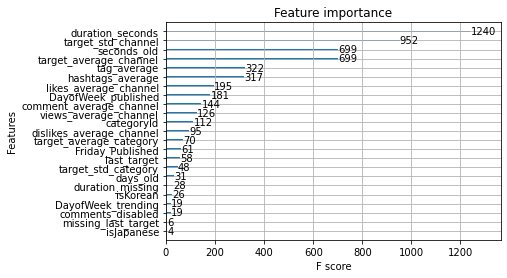

In [ ]:
from xgboost import plot_importance
plot_importance(xgb)

In [ ]:
import lightgbm as lgb
# Gn ver2 ref: n_estimators=2000, not working well
lgb = lgb.LGBMRegressor(n_estimators=1000)
lgb.fit(X_train[FEATURES], y_train)

X_val['predictions'] = lgb.predict(X_val[FEATURES])
X_val['predictions'] =[a if b == 0 else 0 for a,b in zip(X_val.predictions,X_val.ratings_disabled)]
mean_absolute_error(y_val,X_val.predictions)

0.006215978098077346

In [ ]:
dict ={}
for a,b in zip(FEATURES, lgb.feature_importances_):
    dict[a]=b
dict
{k: v for k, v in sorted(dict.items(), key=lambda item: item[1],reverse=True)}

{'DayofWeek_published': 1946,
 'DayofWeek_trending': 354,
 'Friday_Published': 334,
 'Sunday_Published': 0,
 'categoryId': 760,
 'comment_average_channel': 1694,
 'comments_disabled': 40,
 'days_old': 147,
 'dislikes_average_channel': 1871,
 'duration_missing': 55,
 'duration_seconds': 6967,
 'hashtags_average': 1919,
 'isJapanese': 11,
 'isKorean': 113,
 'last_target': 71,
 'likes_average_channel': 1670,
 'missing_last_target': 30,
 'seconds_old': 1979,
 'tag_average': 928,
 'target_average_category': 610,
 'target_average_channel': 2765,
 'target_std_category': 442,
 'target_std_channel': 3828,
 'views_average_channel': 1466}

In [ ]:
# X_val['predictions'] = (0.555*lgb.predict(X_val[FEATURES]) +0.445*xgb.predict(X_val[FEATURES]))
X_val['predictions'] = (0.55*lgb.predict(X_val[FEATURES]) +0.45*xgb.predict(X_val[FEATURES]))
X_val['predictions'] =[a if b == 0 else 0 for a,b in zip(X_val.predictions,X_val.ratings_disabled)]
mean_absolute_error(y_val,X_val.predictions)

0.007055606655116254

In [ ]:
predictions1 = xgb.predict(test_df[FEATURES])
predictions2 = lgb.predict(test_df[FEATURES])
#predictions3 = cat.predict(test_df[FEATURES])
# 0.1448, predictions = (predictions1*0.45)+(predictions2*0.55), original ver 1
# 0.1439, predictions = (predictions1*0.295)+(predictions2*0.705), LGB and XGB 300->500, test_train split 0.20->0.25
# predictions = (predictions1*0.295)+(predictions2*0.705)
# GN ver 2, not working well, predictions = (predictions1*0.45)+(predictions2*0.55)
predictions = (predictions1*0.295)+(predictions2*0.705)

In [ ]:
test_df['target'] = predictions
test_df['target'] =[a if b == 0 else 0 for a,b in zip(test_df.target,test_df.ratings_disabled)]

In [ ]:
test_df[['id','target']].to_csv(filepath+'Submission/Feb3NG_entry5.csv',index=False)